In [1]:
import numpy as np
import gymnasium as gym
# import gym
import matplotlib.pyplot as plt
from IPython import display

In [2]:
import numpy as np
import matplotlib.pyplot as plt

class MultilayerPerceptron:
    def __init__(self, input_size, hidden_layer_sizes, output_size, activation_functions_type):
        self.input_size = input_size
        self.hidden_layer_sizes = hidden_layer_sizes
        self.output_size = output_size
        self.af_type = activation_functions_type
        self.layers = len(hidden_layer_sizes) + 1 

        self.weights = [np.random.random((input_size, hidden_layer_sizes[0]))]
        self.biases = [np.random.random((1, hidden_layer_sizes[0]))]

        for i in range(1, self.layers-1):
            self.weights.append(np.random.random((hidden_layer_sizes[i - 1], hidden_layer_sizes[i])))
            self.biases.append(np.random.random((1, hidden_layer_sizes[i])))
        self.weights.append(np.random.random((hidden_layer_sizes[self.layers-2], output_size)))
        self.biases.append(np.random.random((1, output_size)))
    
    def activation_function(self, x, type='sigmoid'):
        if type == 'sigmoid':
            return 2 / (1 + np.exp(-x)) - 1
        elif type == 'linear':
            return x
        elif type == 'ReLU':
            return np.maximum(0, x)  # ReLU activation function
        elif type == 'tanh':
            return np.tanh(x)
    def activation_function_derivative(self, x, type='sigmoid'):
        if type == 'sigmoid':
            return (1 - self.activation_function(x, type='sigmoid') ** 2) / 2
        elif type == 'linear':
            return 1
        elif type == 'ReLU':
            return np.where(x <= 0, 0, 1)  # Derivative of ReLU
        elif type == 'tanh':
            return 1-np.tanh(x)**2
    def forward(self, x):
        layer_output = x

        for i in range(self.layers):
            layer_input = layer_output @ self.weights[i] + self.biases[i]
            layer_output = self.activation_function(layer_input, self.af_type[i])

        return layer_output

    def gradient_calculation(self, x, e, Ac):
        layer_outputs = [x]
        layer_inputs = []

        # Forward pass
        for i in range(self.layers):
            layer_input = layer_outputs[i] @ self.weights[i] + self.biases[i]
            layer_inputs.append(layer_input)
            layer_output = self.activation_function(layer_input, self.af_type[i])
            layer_outputs.append(layer_output)

        # Backpropagation
        error = (e @ np.linalg.pinv(Ac) @ np.ones([6,1])) - .01*layer_output                       #y - layer_outputs[-1]
        delta = error * self.activation_function_derivative(layer_inputs[-1], self.af_type[-1])
        grads = [{'weights': 0, 'bias': 0} for _ in range(self.layers)]

        for i in range(self.layers - 1, -1, -1):
            grads[i]['weights'] = np.sum(np.expand_dims(delta, 1) * np.expand_dims(layer_outputs[i], 2), 0)
            grads[i]['bias'] = np.sum(delta, axis=0, keepdims=True)
            if i > 0:
                # print(delta.shape, self.weights[i].shape)
                error = delta @ self.weights[i].T
                delta = error * self.activation_function_derivative(layer_inputs[i - 1], self.af_type[i - 1])
        return grads

    def train(self, x, e, Ac, update_step_num=10, learning_rate=0.001):
        for i in range(update_step_num):
            grads = self.gradient_calculation(x, e, Ac)

            for j in range(self.layers):
                self.weights[j] += learning_rate * grads[j]['weights']#np.clip(grads[j]['weights'],-1,1)
                self.biases[j] += learning_rate * grads[j]['bias']#np.clip(grads[j]['bias'],-1,1)


In [3]:
class Jetracer():
    def __init__(self, trajectory = None, StepTime = 0.01):
        super(Jetracer, self).__init__()
        self.xd = trajectory

        self.Ac = -2.45*np.eye(6)
        self.Velocity = 1
        self.dt = StepTime
        self.l_xf = 0.1
        self.l_xr = 0.1

        self.history = []
        self.Velocity = 1
        self.state = np.zeros([3])
        self.counter = 0
        self.step_counter = 0
        self.x = np.zeros([6])
    def step(self, u):
        self.Velocity = u[0,1]
        u = u[0,0]
        BETA = np.arctan(self.l_xf * np.tan(u) / (self.l_xf + self.l_xr))
        state_dot = np.array([self.Velocity * np.cos(self.state[2] + BETA), self.Velocity * np.sin(self.state[2] + BETA),(self.Velocity * np.cos(BETA) / (self.l_xf + self.l_xr)) * np.tan(u)])
        # self.state += state_dot[:,0] * self.dt
        self.state += state_dot * self.dt
        self.history.append(self.state[0:2].tolist())
        self.counter += 1
        self.x = np.concatenate((self.state,state_dot))
        return self.x

In [4]:
import numpy as np
import matplotlib.pyplot as plt

class RBFnn:
    def __init__(self, input_size, neuron_num, output_size):
        self.L = output_size
        self.N = input_size
        self.M = neuron_num
        self.mu = np.ones([input_size, neuron_num])
        self.sigma = np.ones([input_size, neuron_num])
        self.W = np.ones([neuron_num, output_size])
        self.bias = np.zeros([1, output_size])#*0
    # def center_init(self, x):
    #     kmeans = KMeans(n_clusters=self.M, random_state=0, n_init="auto").fit(x)
    #     self.mu = kmeans.cluster_centers_.T
    def forward(self, x):
        phi = np.exp(-((np.expand_dims(x,-1)-np.expand_dims(self.mu,0))/np.expand_dims(self.sigma,0))**2)
        phi = phi.prod(1)
        self.phi = phi
        y_hat = phi @ self.W + self.bias
        return(y_hat)
    def grad(self, x, e, Ac):
        
        # Forward
        y_hat = self.forward(x)
        # grad
        error1 = (e @ np.linalg.pinv(Ac) @ np.ones([6,1])) + 0.01*y_hat #y_hat - y
        error = (np.expand_dims(self.W, 0)*np.expand_dims(error1, 1)).sum(-1)  # sample * neuron_num

        grad_W = (np.expand_dims(self.phi,-1)*np.expand_dims(error1, 1)).sum(0)

        grad_mu = (np.expand_dims(self.phi,1)*(np.expand_dims(x,-1)-np.expand_dims(self.mu,0))/np.expand_dims(self.sigma,0)**2)*np.expand_dims(error, 1)
        grad_mu = grad_mu.mean(0)

        grad_sigma = (np.expand_dims(self.phi,1)*(np.expand_dims(x,-1)-np.expand_dims(self.mu,0))**2/np.expand_dims(self.sigma,0)**3)*np.expand_dims(error, 1)
        grad_sigma = grad_sigma.mean(0)

        grad_bias = error1.mean(-1).mean(0)#*0
        return(grad_W, grad_mu, grad_sigma, grad_bias)
    def Train(self, x, e, Ac, iteration_num = 1000, learning_rate = 0.01):
        # self.center_init(x)
        for i in range(iteration_num):
            grad_W, grad_mu, grad_sigma, grad_bias = self.grad(x, e, Ac)
            self.W -= learning_rate * grad_W
            self.mu -= learning_rate * grad_mu
            self.sigma -= learning_rate * grad_sigma
            self.bias -= learning_rate * grad_bias
            

In [5]:
import numpy as np
import matplotlib.pyplot as plt
Vel = 1
StepTime = 0.001

x = np.array([1,.1,0])
l_xf = 0.1
l_xr = 0.1
u = .2
length = 60000
history = np.zeros([length,6])
ss = []
for i in range(length):
    u = np.sin(i/10000*np.pi*2)
    # Vel = np.cos(i/20000*np.pi*2)
    # ss.append(np.copy(Vel))
    BETA = np.arctan(l_xf * np.tan(u) / (l_xf + l_xr))
    x_dot = np.array([Vel * np.cos(x[2] + BETA),Vel * np.sin(x[2] + BETA),(Vel * np.cos(BETA) / (l_xf + l_xr)) * np.tan(u)])
    x += x_dot * StepTime
    history[i, 0:3] = x#[0:2]
    history[i, 3:] = x_dot
t = np.linspace(0,np.pi*2,1000)
x = np.cos(t)**2
y = np.sin(t)**2
trajectory = np.copy(history)#np.concatenate((x.reshape([-1,1]), y.reshape([-1,1])),1)

In [6]:
# mlp = MultilayerPerceptron(input_size = 12, hidden_layer_sizes = [4, 3], output_size = 2, activation_functions_type = ['tanh', 'tanh', 'linear'])
rbf = RBFnn(input_size = 12, neuron_num = 1, output_size = 2)
plant = Jetracer(trajectory, StepTime = StepTime)
history = {'x': np.zeros([plant.xd.shape[0],2]), 'u':np.zeros([plant.xd.shape[0],2])}
for i in range(plant.xd.shape[0]):
    xc = np.concatenate((np.copy(plant.x), plant.xd[i])).reshape([1,-1])
    e = np.copy(plant.x) - plant.xd[i]

    # u = mlp.forward(xc)
    u = rbf.forward(xc)
    u[0,1] = 1#ss[i]
    plant.step(u)#[0,0]
    history['x'][i] = plant.state[:-1]
    history['u'][i] = u

    # mlp.train(xc, e.T, plant.Ac, update_step_num = 1, learning_rate=0.02)
    rbf.Train(xc, -e.T, plant.Ac, iteration_num = 1, learning_rate=0.02)#0.02


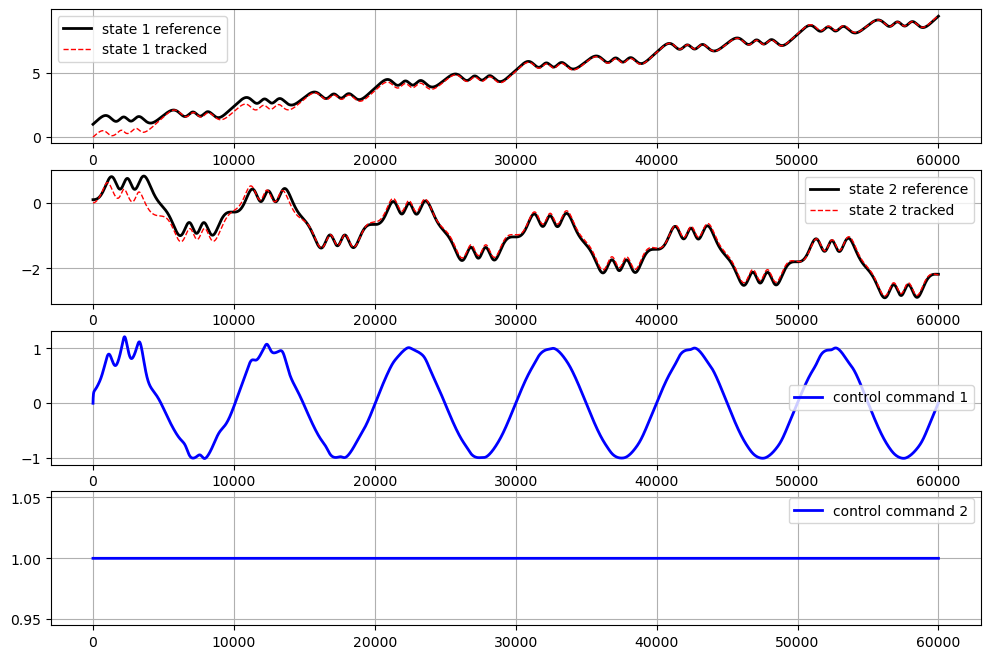

In [7]:
plt.figure(figsize=(12, 8))
plt.subplot(4,1,1)
plt.plot(plant.xd[:,0], 'k-', label='state 1 reference', linewidth = 2)
plt.plot(history['x'][:,0], 'r--', label='state 1 tracked', linewidth = 1)
plt.grid('on')
plt.legend()
plt.subplot(4,1,2)
plt.plot(plant.xd[:,1], 'k-', label='state 2 reference', linewidth = 2)
plt.plot(history['x'][:,1], 'r--', label='state 2 tracked', linewidth = 1)
plt.grid('on')
plt.legend()

plt.subplot(4,1,3)
plt.plot(history['u'][:,0], 'b-', label='control command 1', linewidth = 2)
plt.grid('on')
plt.legend()
plt.subplot(4,1,4)
plt.plot(history['u'][:,1], 'b-', label='control command 2', linewidth = 2)
plt.grid('on')
plt.legend()
plt.savefig('QT_Tracking_Results_1.png', dpi = 400)

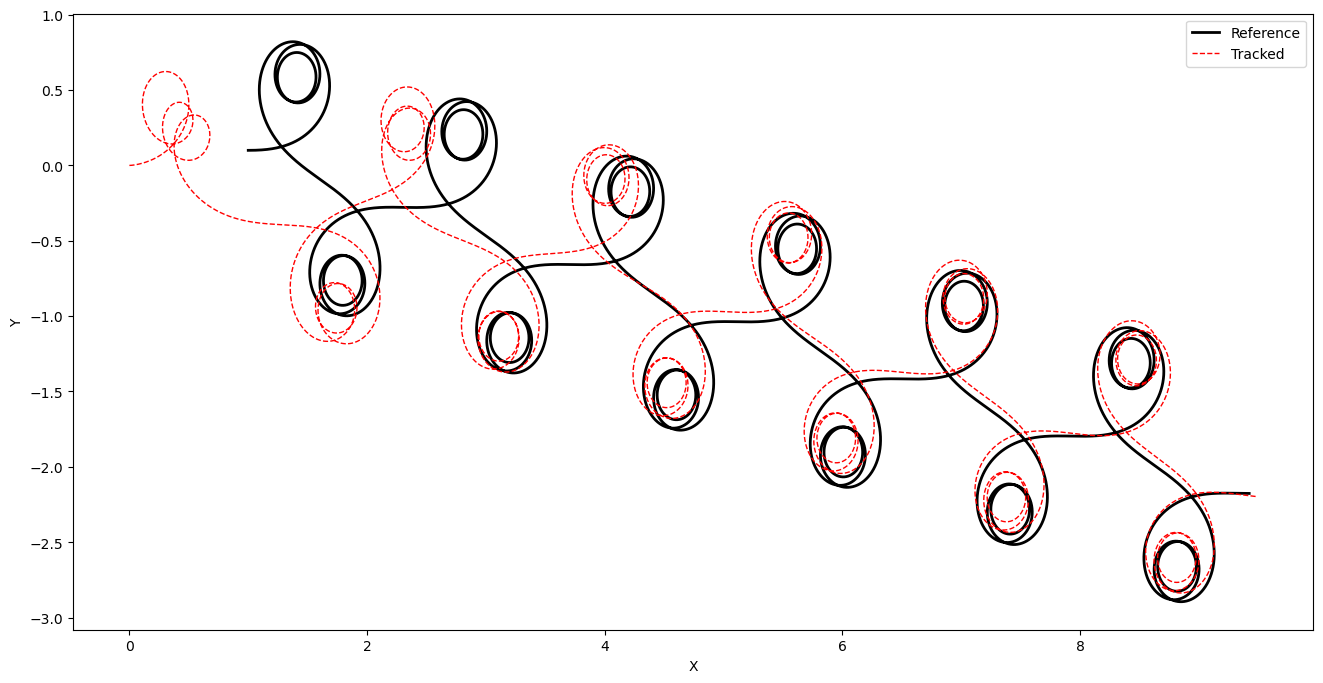

In [8]:
plt.figure(figsize=(16, 8))
plt.plot(plant.xd[:,0], plant.xd[:,1], 'k-', linewidth = 2)
plt.plot(history['x'][:,0], history['x'][:,1], 'r--', linewidth = 1)
plt.legend(['Reference', 'Tracked'])
plt.xlabel('X')
plt.ylabel('Y')
plt.savefig('QT_Tracking_Results_2.png', dpi = 400)